In [122]:
import datetime

import math
import numpy as np
import pandas as pd
import random

from scipy.signal import find_peaks

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [123]:
STOCK_NAME = 'JET AIRWAYS'
STOCK_PRICE_FILE = './../database/532617.csv'

In [124]:
price_data = pd.read_csv(STOCK_PRICE_FILE,index_col = 0, parse_dates = True,
                             usecols = [u'Date',u'Open Price', u'High Price', u'Low Price', u'Close Price'],
                             dtype= {u'Open Price':np.float64,u'High Price':np.float64,
                                     u'Low Price':np.float64,u'Close Price':np.float64}).sort_index()

In [125]:
SAMPLE_LENGTH = 120
start_ix = random.randint(0,len(price_data)-SAMPLE_LENGTH)
sample_data = price_data[start_ix:start_ix+SAMPLE_LENGTH]
sample_data.head(4)

,Open Price,High Price,Low Price,Close Price
Date,,,,
2012-06-21,380.0,381.50,371.20,375.90
2012-06-22,374.0,388.40,369.35,385.05
2012-06-25,390.0,394.45,381.60,384.60
2012-06-26,386.1,393.00,383.90,391.70


In [126]:
def get_peaks(price_seq):
    peaks,peaks_properties = find_peaks(high_price_seq,distance=1,prominence=5)
    return peaks

In [127]:
def get_troughs(price_seq):
    price_seq_inv = price_seq*-1
    troughs,troughs_properties = find_peaks(price_seq_inv,distance=1,prominence=5)
    return troughs

In [128]:
high_price_series = sample_data['High Price']
high_price_seq = high_price_series.values
peak_indices = get_peaks(high_price_seq)
peak_prices = high_price_seq[peak_indices]

In [129]:
def get_slope(x,y):
    dy = np.diff(y)
    dx = np.diff(x)
    slope = np.arctan(dy/dx)
    return np.insert(slope,0,0.0)    

In [130]:
high_slopes = get_slope(peak_indices,peak_prices)
high_trend_data = pd.DataFrame(high_slopes,index = sample_data.index[peak_indices],columns=['high_slope'])

In [131]:
low_price_series = sample_data['Low Price']
low_price_seq = low_price_series.values
trough_indices = get_troughs(low_price_seq)
trough_prices = low_price_seq[trough_indices]

In [132]:
low_slopes = get_slope(trough_indices,trough_prices)
low_trend_data = pd.DataFrame(low_slopes,index = sample_data.index[trough_indices],columns=['low_slope'])

In [133]:
trend_data = sample_data.join(high_trend_data)
trend_data = trend_data.join(low_trend_data)
trend_data = trend_data.fillna(method='bfill')

In [134]:
def get_trend(high_slope,low_slope):
    if math.isnan(high_slope) or math.isnan(low_slope):
        return 'indeterminate'
    elif high_slope == 0.0 and low_slope == 0:
        return 'indeterminate'
    elif high_slope > 0.0 and low_slope > 0.0:
        return 'bullish'
    elif high_slope < 0.0 and low_slope < 0.0:
        return 'bearish'
    else:
        return 'sideways'    

In [135]:
trend_data['trend'] = trend_data.apply(lambda row: get_trend(row['high_slope'], row['low_slope']), axis=1)

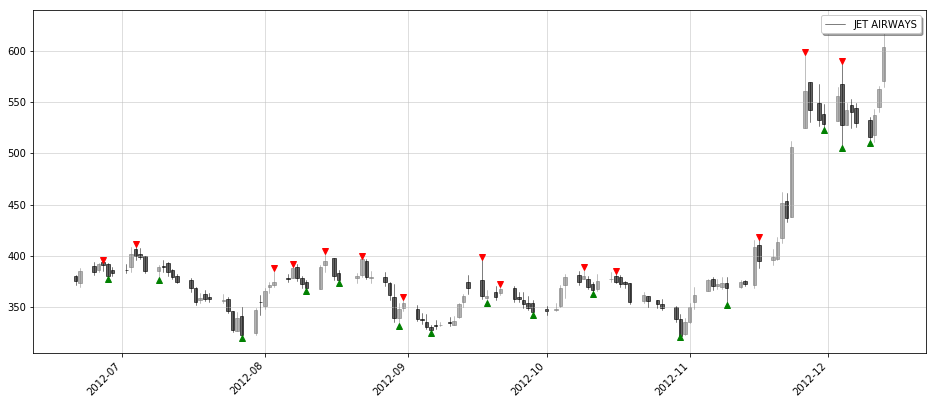

In [136]:
fig, ax = plt.subplots(figsize = (16,7))
fig.subplots_adjust(bottom=0.2)

quotes = zip(mdates.date2num(sample_data.index.to_pydatetime()),sample_data[u'Open Price'], 
                             sample_data[u'High Price'],sample_data[u'Low Price'], sample_data[u'Close Price'])
candlestick_ohlc(ax,quotes,width=0.75,colorup='grey',colordown='black',alpha=0.6)

plt.plot(sample_data.index[peak_indices], pd.Series(high_price_seq,index=sample_data.index)[peak_indices], "v", color='red')
plt.plot(sample_data.index[trough_indices], pd.Series(low_price_seq,index=sample_data.index)[trough_indices], "^", color='green')

ax.xaxis_date()
ax.legend([STOCK_NAME],loc='upper right', shadow=True, fancybox=True)
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)
plt.show()

In [137]:
trend_data['row_num'] = np.arange(len(trend_data))
trend_dict = trend_data[['trend','row_num']].groupby('trend')['row_num'].apply(np.array).to_dict()
trend_dict.pop('indeterminate', None)
COLOR_DICT = {'bearish' : 'red', 'bullish' : 'green', 'sideways' : 'blue'}

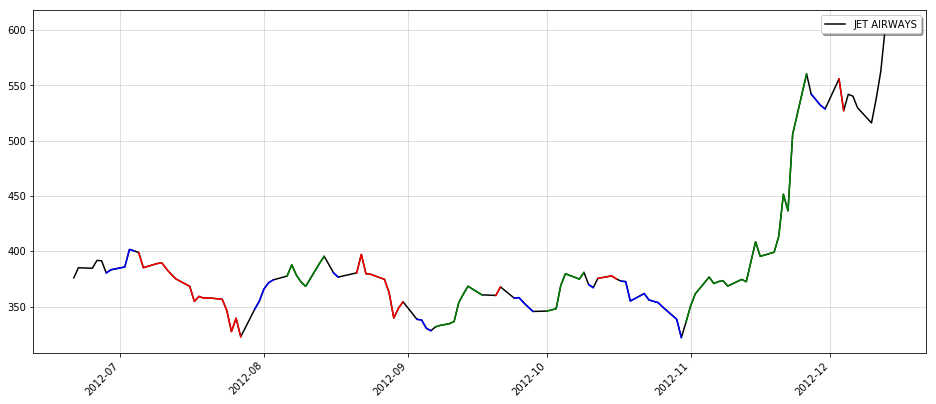

In [138]:
fig, ax = plt.subplots(figsize = (16,7))
fig.subplots_adjust(bottom=0.2)

plt.plot(trend_data['Close Price'],color='black')
for trend_label, trend_indices in trend_dict.items():
    #plt.scatter(sample_data.index[trend_indices], trend_data['Close Price'][trend_indices],color=COLOR_DICT[trend_label])
    plt.plot(trend_data['Close Price'].align(trend_data['Close Price'][trend_indices])[1],color=COLOR_DICT[trend_label])

ax.xaxis_date()
ax.legend([STOCK_NAME],loc='upper right', shadow=True, fancybox=True)
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)
plt.show()